<a href="https://colab.research.google.com/github/Shivakumarsullagaddi/CCBD_MRI/blob/main/2D_RESNET18_BC_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Binary Classification
#2D slices + ResNet18

0 → CN (Not Alzheimer's)

1 → AD (Alzheimer's)



---
Improved from 2nd code

---



*   Applying Data Argumentation
*   DataLoaders (with Hyperparameters)
*   Hyperparameter Tuning
*   considered only AD and CN for even distributuion
*   Added ROC(Recevier Operating Charecteristic)

> ROC -> for checking performance of model on classification,
  Closer the curve towards the top left better the model


```
 FOR ACC need to hit and trial Tunning, need to find it
```

**Problem :** *Model unable to distinguish between the axial,sagatial,coronal*
            

> Insufficient Data and there is no meta data  ->need more subjects and meta data

> MRI Slices May Not Be Discriminative

> Overfitting (Training accuracy is high, but validation accuracy is much lowe)

> Model Limitations  ->need more advanced models

>


get tha dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


import

In [2]:
import os
import random
import torch
import numpy as np
import nibabel as nib
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt

#extra added
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import seaborn as sns


Applying Data Argumentation and Define transformer

In [3]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


custom dataset

In [4]:
class MRISliceDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples  # list of (nii_path, label)
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        nii_path, label = self.samples[idx]
        img = nib.load(nii_path).get_fdata()
        slice_idx = img.shape[2] // 2
        slice_img = img[:, :, slice_idx]
        slice_img = (slice_img - np.min(slice_img)) / (np.max(slice_img) - np.min(slice_img) + 1e-8)
        slice_img = (slice_img * 255).astype(np.uint8)
        pil_img = Image.fromarray(slice_img).convert('RGB')
        if self.transform:
            pil_img = self.transform(pil_img)
        return pil_img, label


prepare subject level

In [5]:
root_dir = '/content/drive/MyDrive/MRI_DATASET/nifti/nifti'
class_names = ['AD', 'CN']  # Only AD and CN
class_map = {'CN': 0, 'AD': 1}
random.seed(42)

train_samples, val_samples, test_samples = [], [], []

for cls in class_names:
    class_dir = os.path.join(root_dir, cls)
    subjects = sorted(os.listdir(class_dir))
    random.shuffle(subjects)
    n_total = len(subjects)
    n_train = int(0.7 * n_total)
    n_val = int(0.15 * n_total)
    n_test = n_total - n_train - n_val

    train_subjs = subjects[:n_train]
    val_subjs = subjects[n_train:n_train+n_val]
    test_subjs = subjects[n_train+n_val:]

    for subj_list, sample_list in zip([train_subjs, val_subjs, test_subjs],
                                      [train_samples, val_samples, test_samples]):
        for subj in subj_list:
            subj_dir = os.path.join(class_dir, subj)
            for f in os.listdir(subj_dir):
                if f.endswith('.nii') or f.endswith('.nii.gz'):
                    sample_list.append((os.path.join(subj_dir, f), class_map[cls]))


Create Datasets and DataLoaders (with Hyperparameters)

In [6]:
batch_size = 32

train_dataset = MRISliceDataset(train_samples, transform=train_transform)
val_dataset = MRISliceDataset(val_samples, transform=val_test_transform)
test_dataset = MRISliceDataset(test_samples, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


load and modify resnet

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = models.resnet18(pretrained=True)
# model.fc = nn.Linear(model.fc.in_features, 2)

# For ResNet50
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)



model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 121MB/s]


Training and Hyperparameter Tuning

In [8]:
learning_rate = 1e-4  # Try 5e-4, 1e-3 for tuning
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

for epoch in range(10):  # Increase epochs as needed
    start_time = time.time()
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    ep_tr_acc = 100 * correct / total

    # Validation phase
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    ep_val_acc = 100 * val_correct / val_total

    duration = time.time() - start_time
    avg_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch: {epoch+1}, Time: {duration:.2f}s, Loss: {avg_loss:.4f}, "
          f"Train_acc: {ep_tr_acc:.2f}%, Val_acc: {ep_val_acc:.2f}%")


Epoch: 1, Time: 238.08s, Loss: 0.6835, Train_acc: 55.48%, Val_acc: 50.00%
Epoch: 2, Time: 145.38s, Loss: 0.5851, Train_acc: 65.81%, Val_acc: 50.00%
Epoch: 3, Time: 149.63s, Loss: 0.4772, Train_acc: 79.35%, Val_acc: 56.25%
Epoch: 4, Time: 147.08s, Loss: 0.3788, Train_acc: 83.23%, Val_acc: 71.88%
Epoch: 5, Time: 142.18s, Loss: 0.3472, Train_acc: 86.45%, Val_acc: 81.25%
Epoch: 6, Time: 145.71s, Loss: 0.2769, Train_acc: 87.10%, Val_acc: 59.38%
Epoch: 7, Time: 155.24s, Loss: 0.2798, Train_acc: 90.32%, Val_acc: 71.88%
Epoch: 8, Time: 148.91s, Loss: 0.1621, Train_acc: 92.90%, Val_acc: 68.75%
Epoch: 9, Time: 143.17s, Loss: 0.1726, Train_acc: 93.55%, Val_acc: 68.75%
Epoch: 10, Time: 145.57s, Loss: 0.1473, Train_acc: 94.19%, Val_acc: 75.00%


Validation and Advanced Metrics

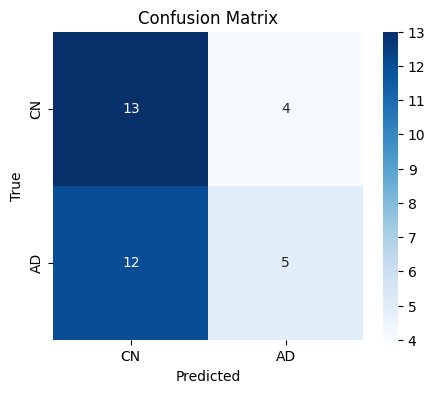

              precision    recall  f1-score   support

          CN       0.52      0.76      0.62        17
          AD       0.56      0.29      0.38        17

    accuracy                           0.53        34
   macro avg       0.54      0.53      0.50        34
weighted avg       0.54      0.53      0.50        34



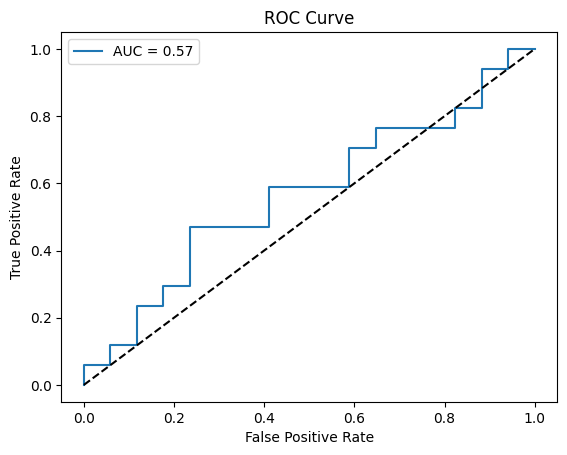

ROC AUC: 0.567


In [9]:
model.eval()
all_preds, all_targets, all_probs = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:,1]
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["CN", "AD"],
            yticklabels=["CN", "AD"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(all_targets, all_preds, target_names=["CN", "AD"]))

# ROC/AUC
auc = roc_auc_score(all_targets, all_probs)
fpr, tpr, _ = roc_curve(all_targets, all_probs)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
print(f"ROC AUC: {auc:.3f}")


#For visualization

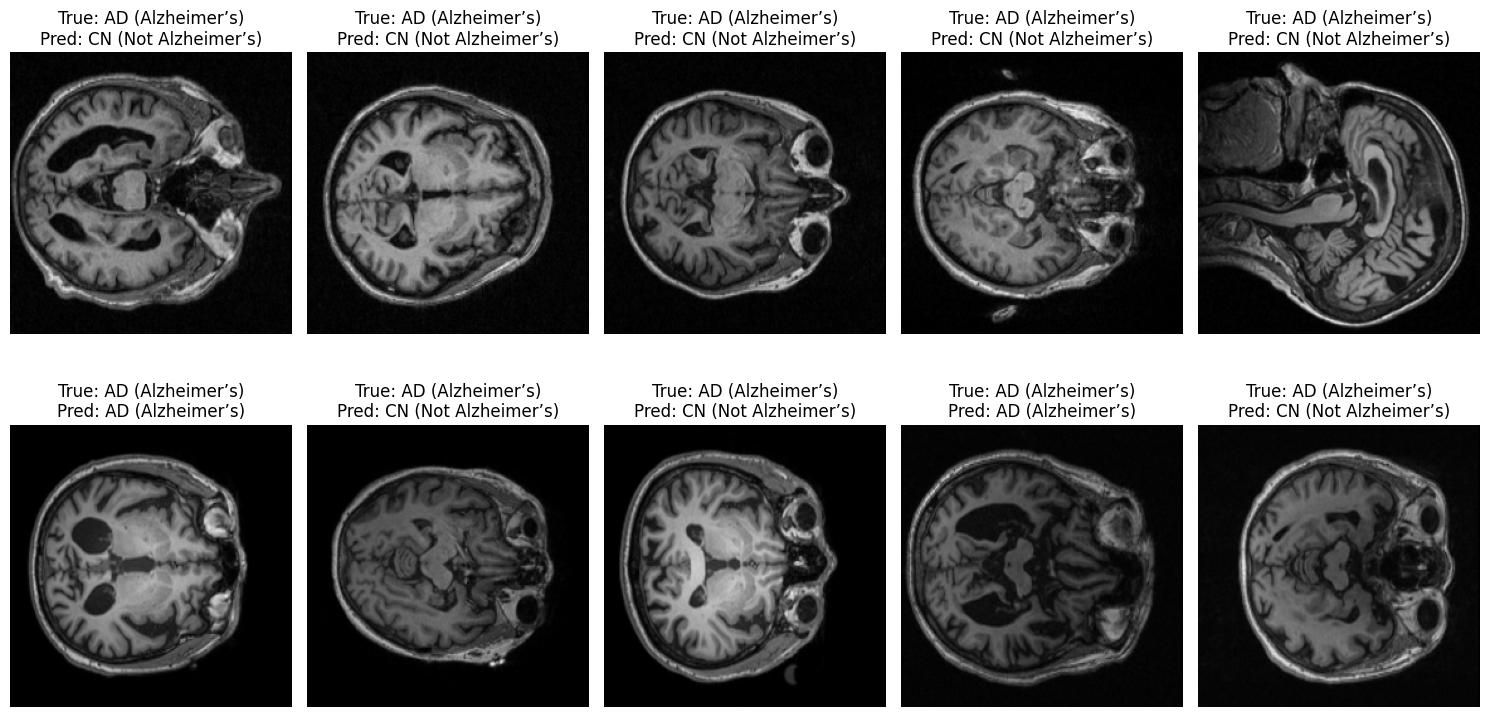

In [10]:
num_examples = 10
plt.figure(figsize=(15, 8))
for idx in range(num_examples):
    img = test_dataset[idx][0].numpy().transpose(1,2,0)
    img = (img * 0.5 + 0.5) * 255
    img = img.astype('uint8')
    true_label = test_dataset[idx][1]
    pred_label = all_preds[idx]
    class_names = {0: "CN (Not Alzheimer’s)", 1: "AD (Alzheimer’s)"}
    plt.subplot(2, 5, idx+1)
    plt.imshow(img)
    plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
